# Reduced Data Exploration

We used UMAP to reduce the dimensionality of the data. Now, we can reasonably cluster and create a classifier for the data

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import umap
import hdbscan
from collections import Counter

In [2]:
primary = pd.read_csv('../data/processed/primary_reduction_neighbors_500_components_50.csv', index_col='Unnamed: 0')
primary_viz = pd.read_csv('../data/meta/primary_tsne.tsv', sep='\t', header=None)
primary.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.905820,4.685900,4.044406,4.587626,10.204649,4.371048,4.889489,8.869814,4.787756,4.291499,...,9.473235,1.147689,9.445981,1.614241,4.584117,1.052150,6.017443,4.116542,2.508994,8.266954
1,0.917982,4.694495,4.059551,4.616160,10.188448,4.379693,4.895364,8.899362,4.787958,4.294628,...,9.472081,1.162867,9.439664,1.613752,4.578678,1.065878,6.011956,4.121254,2.524478,8.254522
2,0.900297,4.679651,4.072043,4.620568,10.187701,4.370939,4.884343,8.882162,4.805419,4.302992,...,9.470544,1.118379,9.447973,1.612516,4.577279,1.047461,6.022335,4.104825,2.520750,8.277589
3,0.965666,4.735350,4.048456,4.553404,10.153872,4.360469,4.902722,8.794043,4.773988,4.298130,...,9.458826,1.170099,9.433373,1.591797,4.546945,1.051983,6.009392,4.096653,2.577206,8.234572
4,0.903214,4.696041,4.054461,4.596351,10.187074,4.358769,4.884483,8.872053,4.789368,4.300343,...,9.461103,1.141835,9.446976,1.602607,4.566032,1.042900,6.018314,4.102317,2.528419,8.252062


In [3]:
prim_umap = pd.read_csv('../data/processed/primary_reduction_neighbors_50_components_3.csv', index_col='Unnamed: 0')

In [4]:
prim_umap.columns

Index(['0', '1', '2'], dtype='object')

Now let's run clustering on the cells

In [14]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, core_dist_n_jobs=1)
clusters = clusterer.fit(primary)

In [15]:
primary['label'] = clusters.labels_

In [16]:
prim_umap['label'] = clusters.labels_

In [17]:
prim_umap.columns

Index(['0', '1', '2', 'label'], dtype='object')

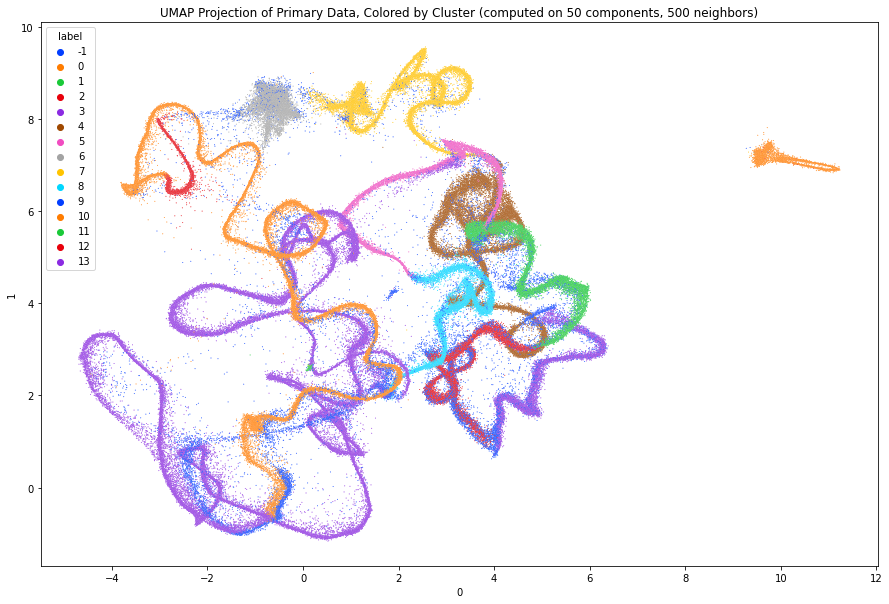

In [18]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

def two_plot(data):
    fig, ax = plt.subplots(figsize=(15, 10))

    sns.scatterplot(
        x='0', 
        y='1',
        data=data,
        hue='label',
        legend='full',
        ax=ax,
        s=1,
        palette='bright'
    )

    plt.title(f'UMAP Projection of Primary Data, Colored by Cluster (computed on 50 components, 500 neighbors)')
    plt.savefig('umap_cluster.png', dpi=300)
    plt.show()

two_plot(prim_umap)

In [10]:
primary[primary['label'] == 7].index

Int64Index([], dtype='int64')

In [11]:
clusters.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
dict(zip(Counter(clusters.labels_).keys(), Counter(clusters.labels_).values()))

{0: 183162, -1: 412, 1: 5835}

## Classification

Now that we have cell clusters, we can build a classifier on the full space of data to learn the mapping between gene expression and cluster.

Ultimately, we'll have to incorporate two more things in our final model's pipeline:
1. Removing inter-experiment variability  
2. "Normalizing" for cell stress

In [13]:
import torch

